## Showing how to use different wind fields for only one simulation 

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, Observation, WindStress
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

All gpu_ctx have to be generated before any of them is used


In [3]:
%cuda_context_handler gpu_ctx

In [4]:
N_winds = 12

In [5]:
gpu_ctx_winds = []
for i in range(N_winds):
    # Generating new contextes without iPythonMagic requires to reset the kernel every time it crashes 
    gpu_ctx_winds.append( Common.CUDAContext() )

Initialise Simulation

In [6]:
nx = 100
ny = 100

dx = 100.0
dy = 100.0

dt = 0.0
g = 9.81
f = 0.0
r = 0.0

ghosts = [2,2,2,2] # north, east, south, west

dataShape = (ny + ghosts[0] + ghosts[2], nx + ghosts[1] + ghosts[3])

eta0 = np.zeros(dataShape, dtype=np.float32)
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)
Hi = 10 * np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')

boundary_conditions = Common.BoundaryConditions(2,2,2,2)

T = 600

In [7]:
wind_t = np.array([0])
wind_u = [np.array([[30]])]
wind_v = [np.array([[ 0]])]

In [8]:
wind = WindStress.WindStress(t=wind_t, wind_u=np.float32(wind_u), wind_v=np.float32(wind_v))

In [9]:
sim = CDKLM16.CDKLM16(gpu_ctx, \
                        eta0, hu0, hv0, Hi, \
                        nx, ny, \
                        dx, dy, dt, \
                        g, f, r, \
                        boundary_conditions=boundary_conditions,
                        wind=wind)

Initialise Drifters (and fake-Observation objects)

In [10]:
import pandas as pd 
forecasts = N_winds*[pd.DataFrame(columns=["time","pos_x", "pos_y"])]

In [11]:
wind4drifters = []
for i in range(N_winds):
    wind4drifters.append( WindStress.WindStress(t=wind_t, wind_u=np.float32([np.array([[10*np.sin(2*np.pi/N_winds*i)]])]), wind_v=np.float32([np.array([[10*np.cos(2*np.pi/N_winds*i)]])])) )

In [12]:
drifterSets = []
for i in range(N_winds):
    drifterSets.append( GPUDrifterCollection.GPUDrifterCollection( gpu_ctx_winds[i], 1, 
                                                 wind = wind4drifters[i], wind_drift_factor=0.02,
                                                 boundaryConditions = sim.boundary_conditions,
                                                 domain_size_x =  sim.nx*sim.dx,
                                                 domain_size_y =  sim.ny*sim.dy,
                                                 gpu_stream = sim.gpu_stream) )
    drifterSets[i].setDrifterPositions([[int(0.5*ny*dy),int(0.5*ny*dy)]])
    drifter_positions = drifterSets[i].getDrifterPositions()[0]
    forecasts[i] = forecasts[i].append({"time":sim.t, "pos_x":drifter_positions[1], "pos_y":drifter_positions[0]}, ignore_index=True)

Simulate and drift

In [13]:
for min in range(T):
    dt = 1
    sim.step(dt)
    for i in range(N_winds):
        drifterSets[i].drift(sim.gpu_data.h0, sim.gpu_data.hu0, sim.gpu_data.hv0, \
                        sim.bathymetry.Bm, sim.nx, sim.ny, sim.t, sim.dx, sim.dy, \
                        dt, np.int32(2), np.int32(2))
        drifter_positions = drifterSets[i].getDrifterPositions()[0]
        forecasts[i] = forecasts[i].append({"time":sim.t, "pos_x":drifter_positions[0], "pos_y":drifter_positions[1]}, ignore_index=True)

Results

In [14]:
drifter_pathes = []
for i in range(N_winds):
    drifter_pathes.append( [forecasts[i]["pos_x"].to_numpy(), forecasts[i]["pos_y"].to_numpy()] )


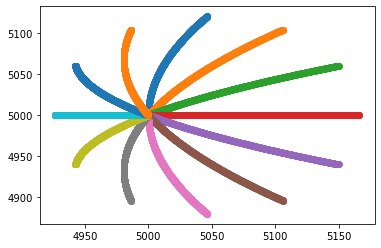

In [15]:
for i in range(N_winds):
    plt.scatter(drifter_pathes[i][0],drifter_pathes[i][1])

In [16]:
drifter_positions

array([4986.3735, 5104.004 ], dtype=float32)

In [17]:
reference_points = []
for i in range(N_winds):
    reference_points.append( [drifter_pathes[i][0][-1], drifter_pathes[i][1][-1]] )

reference_points


[[5046.37353515625, 5120.1171875],
 [5106.373046875, 5104.00390625],
 [5150.29638671875, 5060.05859375],
 [5166.3740234375, 5000.0],
 [5150.29638671875, 4939.94140625],
 [5106.373046875, 4895.99609375],
 [5046.37353515625, 4879.8828125],
 [4986.37353515625, 4895.99609375],
 [4942.4501953125, 4939.94140625],
 [4926.373046875, 5000.0],
 [4942.4501953125, 5060.05859375],
 [4986.37353515625, 5104.00390625]]

In [18]:
ref = [[5046.37353515625, 5120.1171875],
 [5106.373046875, 5104.00390625],
 [5150.29638671875, 5060.05859375],
 [5166.3740234375, 5000.0],
 [5150.29638671875, 4939.94140625],
 [5106.373046875, 4895.99609375],
 [5046.37353515625, 4879.8828125],
 [4986.37353515625, 4895.99609375],
 [4942.4501953125, 4939.94140625],
 [4926.373046875, 5000.0],
 [4942.4501953125, 5060.05859375],
 [4986.37353515625, 5104.00390625]]

In [19]:
np.array(reference_points) - np.array(ref)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])